<a href="https://colab.research.google.com/github/vagi8/deepWeed/blob/main/deepWeed_agave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
path=''

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import cv2
import random
from datetime import datetime
from glob import glob
from os import listdir
import pickle
from skimage import io

In [ ]:
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision,Recall,AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16,ResNet50

In [ ]:
with open(path+'weed_train_array.pkl', 'rb') as input:
    data = pickle.load(input)

In [ ]:
combined_data=np.array(data)
X = []
y = []
specices=[]
for features,label,specice in combined_data:
    X.append(features)
    y.append(label)
    if specice not in specices:
      specices.append(specice)

# reshape X data to make valid 4D data with numpy
X = np.array(X).reshape(-1, 64, 64, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
#creating a Map for labels

unique_label=set(y)

In [ ]:
# dog_breed=['great_pyrenees','kuvasz','american_staffordshire_terrier','welsh_springer_spaniel','curly-coated_retriever','irish_water_spaniel','brittany_spaniel','miniature_pinscher','siberian_husky','silky_terrier','soft-coated_wheaten_terrier','staffordshire_bullterrier','standard_poodle','standard_schnauzer','sussex_spaniel','tibetan_mastiff','tibetan_terrier','toy_poodle','scottish_deerhound','maltese_dog']
# len(dog_breed)
# images=[]
# for i in dog_breed:
#   images.append(X[y.index(i)])

In [ ]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os

def display_images(
    images: [PilImage], labels,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    # if len(images) > max_images:
    #     print(f"Showing {max_images} images of {len(images)}:")
    #     images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        plt.title(labels[i])
        # if hasattr(image, 'filename'):
        #     title=image.filename
        #     if title.endswith("/"): title = title[0:-1]
        #     title=os.path.basename(title)
        #     title=textwrap.wrap(title, label_wrap_length)
        #     title="\n".join(title)
        #     plt.title(title, fontsize=label_font_size); 

In [ ]:
# display_images(images,dog_breed)
# img = X[y.index(118)]
# display_images([img],['boston_bull'])

In [ ]:
# unique_label=list(unique_label)
# for i in range(len(y)):
#   y[i]=unique_label.index(y[i])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_val.shape,y_val.shape)


In [ ]:
#loading vgg16 as base model 
base_model = VGG16(input_shape=(64,64,3),include_top=False,weights="imagenet")

# Freezing base model Layers 
for layer in base_model.layers:
    layer.trainable=False
    
# Building our custom model layers on top of base model 
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
# model.add(Dense(2,activation='softmax'))
model.add(Dense(9,activation='sigmoid'))

# defining f1_scroe mteric algorithm
def f1_score(y_true, y_pred):
    true_positives_values = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positive_value = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives_value = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives_values / (predicted_positives_value + K.epsilon())
    recall = true_positives_values / (possible_positive_value + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Model metrics options
METRICS = [BinaryAccuracy(name='accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc'),f1_score]

# Using this we can improve out effciency of traning
# This primarily Reduces learning rate when a metric has stopped improving.

reducelr_plateau = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)

# create a model checkpoint (save a model locally so to be used later.) 
# A checkpoint works like a race checkpoint. Even if model has stoped training in the middle, one can continue traning from that checkpoint
model_checkpoint = ModelCheckpoint(filepath=path+str(datetime.now()) + 'VGG16_model.h5',save_freq='epoch',period=1)

# This will stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(verbose=1, patience=5)

# Configuring our model
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

# Training
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 3,callbacks=[reducelr_plateau,model_checkpoint,early_stopping])

# serialize model architecture to JSON
model_json = model.to_json()
with open(path+str(datetime.now())+"VGG16_model.json", "w") as json_file:
    json_file.write(model_json)
# with open(path+str(datetime.now())+'VGG16_history.pkl', 'wb') as output:
#   pickle.dump(idc_class_0_array, output, pickle.HIGHEST_PROTOCOL)
# serialize weights to HDF5
# model.save_weights("model.h5")
print("Saved model to disk")
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

# Function to create model training stats
def train_Validation_plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle("Visualization of Model")
    
    # Figure 1
    fig,ax = plt.subplots(figsize= (20,5))
    ax.plot(range(1, len(acc) + 1), acc)
    ax.plot(range(1, len(val_acc) + 1), val_acc)
    ax.set_title('Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend(['training', 'validation'])
    
    # Figure 2
    fig,ax = plt.subplots(figsize= (20,5))
    ax.plot(range(1, len(loss) + 1), loss)
    ax.plot(range(1, len(val_loss) + 1), val_loss)
    ax.set_title('Loss Curve')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['training', 'validation'])
    
    # Figure 3
    fig,ax = plt.subplots(figsize= (20,5))
    ax.plot(range(1, len(auc) + 1), auc)
    ax.plot(range(1, len(val_auc) + 1), val_auc)
    ax.set_title('AUC Curve')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('AUC')
    ax.legend(['training', 'validation'])
    
    # Figure 4
    fig,ax = plt.subplots(figsize= (20,5))
    ax.plot(range(1, len(precision) + 1), precision)
    ax.plot(range(1, len(val_precision) + 1), val_precision)
    ax.set_title('Precision')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Precision')
    ax.legend(['training', 'validation'])
    
    # Figure 5
    fig,ax = plt.subplots(figsize= (20,5))
    ax.plot(range(1, len(f1) + 1), f1)
    ax.plot(range(1, len(val_f1) + 1), val_f1)
    ax.set_title('F1-score')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 score')
    ax.legend(['training', 'validation'])
    
    plt.show()

# Getting model stats Graph
train_Validation_plot(history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss'],history.history['auc'],history.history['val_auc'],history.history['precision'],history.history['val_precision'],history.history['f1_score'],history.history['val_f1_score'])
final_model=model


In [ ]:
saved_model_config_path = '/content/drive/MyDrive/2021-11-02 07:22:18.859958VGG16_model.json'
saved_model_weights_path = '/content/drive/MyDrive/2021-11-02 06:54:54.906552VGG16_model.h5'
json_file = open(saved_model_config_path, 'r')
loaded_model_json = json_file.read()
json_file.close()

In [ ]:
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(saved_model_weights_path)
print("Loaded model from disk")
  
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, np.array(y), verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
final_model=loaded_model

Loaded model from disk


In [ ]:
# test_img_path= '/content/drive/MyDrive/0a7899ed6a15f4af8f28e01c9c44dcfe.jpg'
# img = cv2.imread(test_img_path,cv2.IMREAD_COLOR)
# img_sized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
# Xnew = np.array(img_sized).reshape(-1,128, 128, 3)
# ynew = final_model.predict(Xnew)
# pred=ynew.tolist()
# unique_label[pred[0].index(max(pred[0]))]

In [ ]:
unique_label=list(unique_label)
y_pred=[]
i=0
for img in X_val:
  img = np.array(img).reshape(-1,64, 64, 3)
  ynew = final_model.predict(img)
  pred = ynew.tolist()
  temp=unique_label[pred[0].index(max(pred[0]))]
  print(f"{i} = {temp}")
  y_pred.append(temp)
  i+=1

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
print(type(y_val))
print(len(y_pred))

<class 'list'>
4203


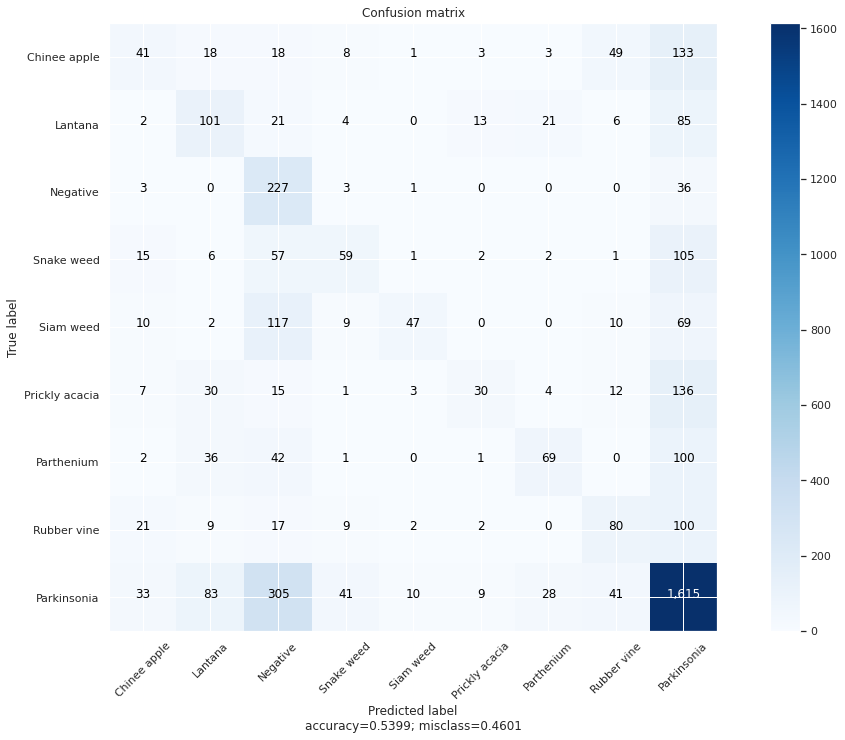

In [ ]:
all_labels_list=y_val
all_preds_list=y_pred
plot_confusion_matrix(cm=confusion_matrix(y_true=all_labels_list, y_pred=all_preds_list), target_names=specices, normalize=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, target_names=specices))

                precision    recall  f1-score   support

  Chinee apple       0.31      0.15      0.20       274
       Lantana       0.35      0.40      0.38       253
      Negative       0.28      0.84      0.42       270
    Snake weed       0.44      0.24      0.31       248
     Siam weed       0.72      0.18      0.29       264
Prickly acacia       0.50      0.13      0.20       238
    Parthenium       0.54      0.27      0.37       251
   Rubber vine       0.40      0.33      0.36       240
   Parkinsonia       0.68      0.75      0.71      2165

      accuracy                           0.54      4203
     macro avg       0.47      0.37      0.36      4203
  weighted avg       0.56      0.54      0.52      4203

